##Clasificación de Razas de Mascotas con Transfer Learning y Fine-Tuning
#Importar librerías necesarias

In [ ]:
# Importamos la librería TensorFlow para construir y entrenar modelos de aprendizaje profundo
import tensorflow as tf

# Importamos TensorFlow Datasets, que facilita la carga de conjuntos de datos estándar
import tensorflow_datasets as tfds

# Importamos Matplotlib para crear gráficos y visualizar imágenes y resultados
import matplotlib.pyplot as plt

# Importamos NumPy para operaciones numéricas eficientes, como manipulación de arrays
import numpy as np

# Importa la función de preprocesamiento específica para EfficientNet
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

# Importa módulos de capas y modelos de Keras, API de alto nivel de TensorFlow
from tensorflow.keras import layers, models

#1- Exploración y preprocesamiento de datos:

In [ ]:
# Cargamos el dataset 'oxford_iiit_pet' desde tensorflow_datasets
# con sus divisiones de entrenamiento train y test
(ds_train, ds_test), ds_info = tfds.load(
    'oxford_iiit_pet',                    # Nombre del dataset
    split=['train', 'test'],              # Divisiones que queremos cargar
    shuffle_files=True,                   # Barajar archivos para más variedad
    as_supervised=True,                   # Devuelve tuplas, osea imagen, etiqueta
    with_info=True                        # También devuelve info del dataset
)

# Exploramos el dataset: cantidad de clases y estructura de etiquetas
num_classes = ds_info.features['label'].num_classes
print("Número de clases:", num_classes)
print("Descripción de las clases:", ds_info.features['label'].names)

# Definimos una función de preprocesamiento que se aplicará a cada imagen
def preprocess_image(image, label):
    # Redimensionamos la imagen a 224x224 píxeles, como requiere EfficientNetV2
    image = tf.image.resize(image, [224, 224])

    # Normalizamos los píxeles usando la función específica del modelo
    image = preprocess_input(image)

    # Retornamos la imagen procesada junto con su etiqueta original
    return image, label

# Aplicamos la función de preprocesamiento al dataset de entrenamiento
ds_train = ds_train.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Aplicamos la función de preprocesamiento al dataset de prueba
ds_test = ds_test.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Optimizamos el rendimiento con batching y prefetching
batch_size = 32

ds_train = ds_train.batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size).prefetch(tf.data.AUTOTUNE)

Número de clases: 37
Descripción de las clases: ['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


#2- Fase 1: Modelado con Extracción de Características:

In [ ]:
# Permite usar Transfer Learning fácilmente con pesos robustos ya aprendidos.
from tensorflow.keras.applications import EfficientNetV2B0

# Cargamos la base convolucional EfficientNetV2B0 SIN la capa superior (include_top=False)
# Usamos pesos pre-entrenados en ImageNet para aprovechar el aprendizaje previo
base_model = EfficientNetV2B0(
    include_top=False,           # No incluimos la capa de clasificación final
    weights='imagenet',          # Cargamos pesos pre-entrenados en ImageNet
    input_shape=(224, 224, 3)    # Tamaño esperado de las imágenes
)

# Congelamos la base del modelo para que sus pesos NO se actualicen durante el entrenamiento inicial
base_model.trainable = False

# Creamos el modelo usando la API funcional de Keras
# Añadimos una nueva "cabeza" clasificadora encima del modelo base congelado
inputs = layers.Input(shape=(224, 224, 3))                # Entrada del modelo
x = base_model(inputs, training=False)                    # Pasamos la entrada por la base congelada
x = layers.GlobalAveragePooling2D()(x)                    # Promediamos espacialmente las activaciones
x = layers.Dropout(0.2)(x)                                # Dropout para reducir sobreajuste 20%
outputs = layers.Dense(37, activation='softmax')(x)       # Capa de clasificación final con 37 clases

# Definimos el modelo completo: entrada, base congelada, cabeza clasificadora
model = models.Model(inputs, outputs)

# Compilamos el modelo con configuración estándar para clasificación multiclase
model.compile(
    optimizer=tf.keras.optimizers.Adam(),                 # Optimizador Adam
    loss='sparse_categorical_crossentropy',               # Usamos sparse porque las etiquetas son enteros
    metrics=['accuracy']                                  # Métrica principal: exactitud
)

# Entrenamos el modelo durante 15 épocas
# Solo se entrenará la cabeza clasificadora porque la base está congelada
history = model.fit(
    ds_train,                # Dataset de entrenamiento ya preprocesado
    validation_data=ds_test, # Dataset de validación
    epochs=15                # Número de épocas sugerido para convergencia inicial
)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 57s 255ms/step - accuracy: 0.5040 - loss: 2.2438 - val_accuracy: 0.8880 - val_loss: 0.5350
Epoch 2/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - accuracy: 0.9143 - loss: 0.4326 - val_accuracy: 0.9092 - val_loss: 0.3566
Epoch 3/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.9425 - loss: 0.2779 - val_accuracy: 0.9182 - val_loss: 0.2985
Epoch 4/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.9574 - loss: 0.2033 - val_accuracy: 0.9204 - val_loss: 0.2721
Epoch 5/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.9644 - loss: 0.1768 - val_accuracy: 0.9223 - val_loss: 0.2545
Epoch 6/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 163ms/step - accuracy: 0.9728 - loss: 0.1369 - val_accuracy: 0.9261 - val_loss: 0.2451
Epoch 7/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 172ms/step - accuracy: 0.9758 - loss: 0.1201 - val_accuracy: 0.9272 - val_loss: 0.2404
Epoch 8/15
115/115 ━━━━━━━━━━━━━

#3- Fase 2: Modelado con Fine-Tuning:

In [ ]:
# Descongelamos toda la base del modelo para permitir entrenamiento completo
base_model.trainable = True

# Mostramos cuántas capas tiene el modelo base
print("Número total de capas en el modelo base:", len(base_model.layers))

# Para evitar el olvido catastrófico, congelamos nuevamente la mayoría de las capas
# Solo las últimas 40 capas se dejarán entrenables
for layer in base_model.layers[:-40]:
    layer.trainable = False  # Congelamos las capas iniciales

# Recompilamos el modelo con un optimizador más conservador
# Usamos Adam con una tasa de aprendizaje muy baja (1e-5) para fine-tuning cuidadoso
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # LR muy bajo
    loss='sparse_categorical_crossentropy',                 # Mismo loss que antes
    metrics=['accuracy']                                    # Seguimos evaluando con exactitud
)

# Continuamos el entrenamiento del modelo desde donde quedó (época 15)
# Entrenamos 10 épocas más, hasta la época 25
history_finetune = model.fit(
    ds_train,                # Dataset de entrenamiento
    validation_data=ds_test, # Dataset de validación
    epochs=25,               # Número total de épocas (anterior + 10)
    initial_epoch=15         # Punto de partida para continuar el historial
)

Número total de capas en el modelo base: 270
Epoch 16/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 66s 287ms/step - accuracy: 0.9802 - loss: 0.1030 - val_accuracy: 0.9250 - val_loss: 0.2447
Epoch 17/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 164ms/step - accuracy: 0.9818 - loss: 0.0961 - val_accuracy: 0.9275 - val_loss: 0.2396
Epoch 18/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 31s 268ms/step - accuracy: 0.9814 - loss: 0.0897 - val_accuracy: 0.9286 - val_loss: 0.2364
Epoch 19/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - accuracy: 0.9896 - loss: 0.0760 - val_accuracy: 0.9291 - val_loss: 0.2346
Epoch 20/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 30s 266ms/step - accuracy: 0.9877 - loss: 0.0753 - val_accuracy: 0.9291 - val_loss: 0.2327
Epoch 21/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - accuracy: 0.9880 - loss: 0.0725 - val_accuracy: 0.9308 - val_loss: 0.2311
Epoch 22/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.9895 - loss: 0.0744 - val_accuracy: 0.9291 - val_loss: 0.2305
Epoch 23/25
115/115 ━━━━━━━━━━━

#4- Evaluación del modelo:

Precisión final en test (Fase 1 - Transfer Learning): 0.9261
Precisión final en test (Fase 2 - Fine-Tuning): 0.9308


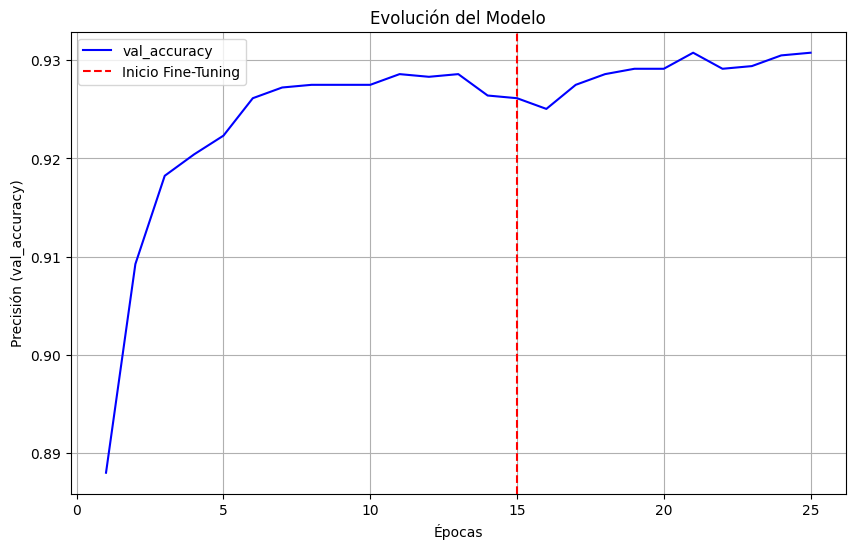

In [ ]:
# Extraemos la precisión final del conjunto de prueba al final de la Fase 1
# Se encuentra en el historial original (hasta epoch 15)
final_acc_phase1 = history.history['val_accuracy'][-1]
print("Precisión final en test (Fase 1 - Transfer Learning):", round(final_acc_phase1, 4))

# Extraemos la precisión final del conjunto de prueba al final de la Fase 2
# Se encuentra en el historial de fine-tuning (hasta epoch 25)
final_acc_phase2 = history_finetune.history['val_accuracy'][-1]
print("Precisión final en test (Fase 2 - Fine-Tuning):", round(final_acc_phase2, 4))

# Unimos las curvas de val_accuracy de ambas fases para construir una sola gráfica
# history.history contiene val_accuracy de las primeras 15 épocas
# history_finetune.history contiene val_accuracy de las épocas 16 a 25
val_acc_total = history.history['val_accuracy'] + history_finetune.history['val_accuracy']

# Creamos la figura para visualizar la evolución de la precisión en validación
plt.figure(figsize=(10, 6))

# Graficamos la curva de val_accuracy
plt.plot(range(1, 26), val_acc_total, label='val_accuracy', color='blue')

# Añadimos una línea vertical en la época 15 (inicio del fine-tuning)
plt.axvline(x=15, color='red', linestyle='--', label='Inicio Fine-Tuning')

# Añadimos etiquetas y leyenda
plt.title('Evolución del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión (val_accuracy)')
plt.legend()
plt.grid(True)

# Mostramos la gráfica
plt.show()

En el gráfico se puede observar, que el modelo alcanzó una precisión sobresaliente tras el Transfer Learning (92.61%), y que el Fine-Tuning logró un pequeño pero valioso incremento (93.08%), lo que sugiere que las capas profundas ajustaron bien al dominio de razas de mascotas.

##Matriz de confusión para visualizar ejemplos mal clasificados:

115/115 ━━━━━━━━━━━━━━━━━━━━ 23s 149ms/step


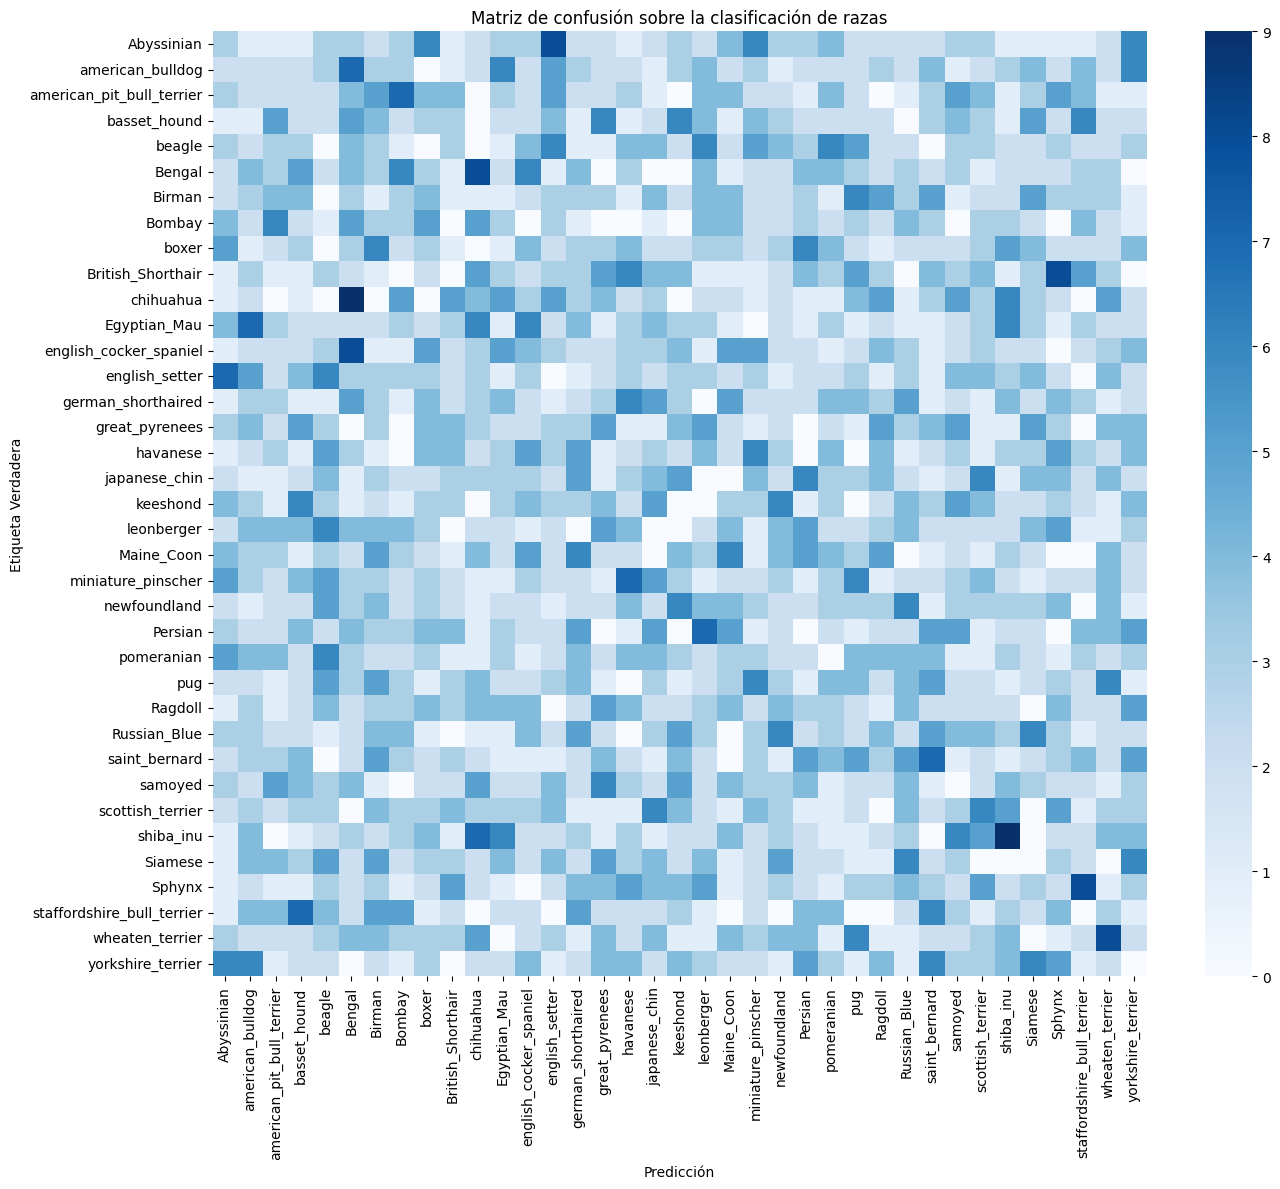

In [ ]:
# #Importar librerías necesarias
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Obtener predicciones del modelo sobre el conjunto de test
# Usamos model.predict() para obtener probabilidades sobre cada clase
y_pred_probs = model.predict(ds_test)  # Salida: array [batch, 37]

# Convertimos las probabilidades en clases predichas
# Tomamos el índice de la clase con mayor probabilidad en cada ejemplo
y_pred = np.argmax(y_pred_probs, axis=1)

# Extraemos las verdaderas etiquetas del dataset de prueba
# Creamos una lista de etiquetas reales para comparación
y_true = []
for images, labels in ds_test.unbatch():
    y_true.append(int(labels.numpy()))
y_true = np.array(y_true)

# Generamos la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizamos la matriz con seaborn para mejor legibilidad
plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix, cmap="Blues", annot=False, fmt='d', xticklabels=ds_info.features['label'].names, yticklabels=ds_info.features['label'].names)
plt.title("Matriz de confusión sobre la clasificación de razas")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Verdadera")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##Análisis de la Matriz de Confusión:

Razas como Abyssinian, Bengal, Pomeranian y Egyptian Mau parecen tener alta precisión, posiblemente por sus rasgos visuales distintivos.

En cambio hubo areas de confusión por ser similares morfológicamente como las siguientes razas;
- American Bulldog vs American Pit Bull Terrier
- English Cocker Spaniel vs English Setter


##Predicciones de prueba:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


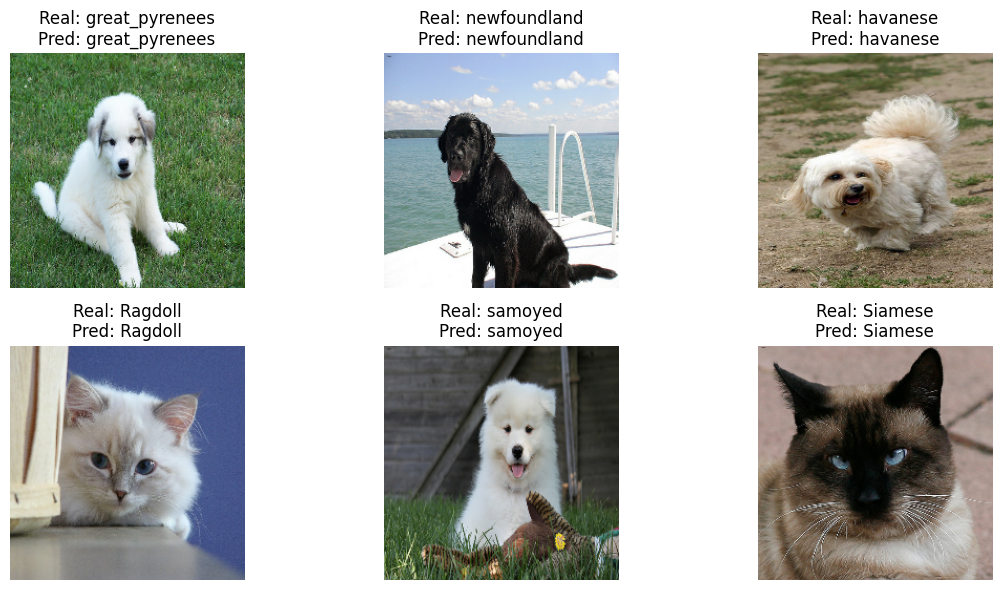

In [ ]:
# Importa la librería random para operaciones aleatorias, como seleccionar ejemplos
import random

# Obtenemos los nombres de las clases
class_names = ds_info.features['label'].names

# Desagrupamos el dataset de prueba para acceder a imágenes individuales
all_samples = list(ds_test.unbatch().take(100))  # Tomamos 100 muestras para variedad

# Seleccionamos 6 muestras aleatorias
random_samples = random.sample(all_samples, 6)

# Separamos imágenes y etiquetas
images = [img for img, lbl in random_samples]
labels = [lbl for img, lbl in random_samples]

# Convertimos en tensors para predicción en batch
images_batch = tf.stack(images)
labels_batch = tf.stack(labels)

# Realizamos predicciones del modelo
preds = model.predict(images_batch)

# Tomamos las clases predichas (índice con mayor probabilidad)
pred_labels = np.argmax(preds, axis=1)

# Visualización con nombres de razas
plt.figure(figsize=(12, 6))

for i in range(6):
    img = images_batch[i].numpy()

    # Escalamos si la imagen está en rango [0, 1]
    if img.max() <= 1.0:
        img = (img * 255).astype("uint8")
    else:
        img = img.astype("uint8")

    # Mostramos la imagen
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)

    # Título con nombre de raza real y predicha
    real_name = class_names[labels_batch[i].numpy()]
    pred_name = class_names[pred_labels[i]]
    plt.title(f"Real: {real_name}\nPred: {pred_name}")
    plt.axis("off")

plt.tight_layout()
plt.show()

#5- Discusión y análisis
##A.
Teniendo en cuenta los siguientes resultados de:
- Transfer Learning (Fase 1): precisión final en test = 92.61%
- Fine-Tuning (Fase 2): precisión final en test = 93.08%

¿Mejoró el fine-tuning?

Sí, hubo mejora, aunque fue poca, un incremento de 0.47 puntos porcentuales. No se trata de una diferencia radical, es indicativa de una optimización fina del modelo en su dominio específico (razas de mascotas).

¿Fue la mejora sustancial?

Depende del enfoque, ya que en una métrica absoluta, su mejora es pequeña pero real por lo tanto puede no justificar mayor coste computacional y en un ajuste fino, indica que las capas profundas sí pudieron refinar patrones visuales.

##B.
Es fundamental entrenar la cabeza clasificadora con la base congelada ya que:
- Evita el sobreajuste temprano, la base convolucional (EfficientNetV2B0 en este caso) ya detecta bordes, texturas y formas generales útiles
- Aprovecha el conocimiento previo
- Permite una adaptación gradual


Asi mismo, tambien es fundamental usar una tasa de aprendizaje muy baja durante el fine-tuning ya que:
- Protege los filtros valiosos
- Evita el “olvido catastrófico”
- Fomenta ajustes sutiles, al mantener el learning rate bajo (1e-5 o similar)

##C
Si tuviera que mejorar aún más el modelo y sin caer en sobreajuste o sobrecostos computacionales, utilizaria la regularización con MixUp o CutMix, ya que:

- En este dataset se presenta razas similares morfológicamente (pugs vs bulldogs, ragdolls vs persians).
- Estas técnicas mejoran la robustez del clasificador ante ambigüedad visual y evitan que dependa de una sola zona del animal.

En conclusión, con MixUp o CutMix habria una mejor generalización, menor dependencia de detalles específicos del pelaje o la pose, lo que es clave para razas difíciles de distinguir.
